In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import gibbs_sampler_poise
import kl_divergence_calculator
from torchvision.utils import save_image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.nn import functional as F  #for the activation function
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torchvision
import random
random.seed(30)

importing Jupyter notebook from gibbs_sampler_poise.ipynb
importing Jupyter notebook from kl_divergence_calculator.ipynb


In [2]:
def sample(mu, var, nb_samples):
    """
    :param mu: torch.Tensor (features)
    :param var: torch.Tensor (features) (note: zero covariance)
    :return: torch.Tensor (nb_samples, features)
    """
    out = []
    for i in range(nb_samples):
        out += [torch.normal(mu, var.sqrt())]
    return torch.stack(out, dim=0)

**Synthetic dataset**
The mean and variance of the first dataset be given by
<span class="math display">
    \begin{aligned}
    \mu_1&=1\\
    \sigma_1 &=1
    \end{aligned}
</span>

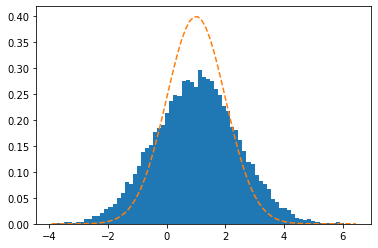

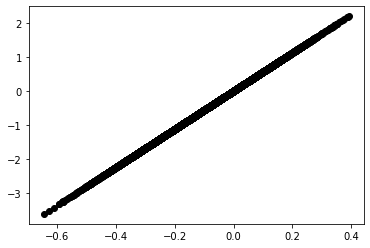

In [3]:
## Creating synthetic datasets
nb_samples=20000
mu1  =torch.tensor(1.)   # . converts long to float
var1 =torch.tensor(1.0)

inp_data1=sample(mu1,var1,nb_samples)  
inp_data1=inp_data1.unsqueeze(0)+torch.randn_like(inp_data1)##Adding gaussian noise to data
inp_data1=torch.transpose(inp_data1,0,1)
## for data visualization
data_vis1=inp_data1.numpy()
#Panel a
n1,bins1,patches1=plt.hist(data_vis1,'auto',density=1)
y1=1/(np.sqrt(2*np.pi*var1))*np.exp(-0.5*(bins1-mu1.numpy())**2/var1)
plt.plot(bins1,y1,'--')
plt.show()
## Transforming data to a higher dimension
"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
dim_exp = 2 
fun_A1   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
data1    = inp_data1*fun_A1
x1_cord = data1[:,0]
y1_cord = data1[:,1]
plt.plot(x1_cord,y1_cord, 'o', color='black')
plt.show()

In [4]:
## Hyperparameters
epochs     = 100
batch_size = 128
lr         = 1e-4
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tx = transforms.ToTensor()

In [5]:
## Creating synthetic dataloader

train_loader_set1 = DataLoader(
    data1[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)
test_loader_set1 = DataLoader(
    data1[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)
train_mnist = datasets.MNIST(
    root="/home/achint/Practice_code/VAE/MNIST",
    train=True,
    download=True,
    transform=tx
)
test_mnist = datasets.MNIST(
    root="/home/achint/Practice_code/VAE/MNIST",
    train=False,
    download=True,
    transform=tx
)
# training and validation data loaders
mnist_train_loader = DataLoader(
    train_mnist,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)
mnist_val_loader = DataLoader(
    test_mnist,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

In [6]:
latent_dim1 = 1
latent_dim2 = 32
dim_MNIST   = 784
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.gibbs                   = gibbs_sampler_poise.gibbs_sampler()  
        self.kl_div                  = kl_divergence_calculator.kl_divergence()
        ## Encoder set1(Gaussian)
        self.set1_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim1)
        self.set1_enc2 = nn.Linear(in_features = 2*latent_dim1,out_features = 2*latent_dim1)
        ## Encoder set2(MNIST)
        self.set2_enc1 = nn.Linear(in_features = dim_MNIST,out_features = 512)
        self.set2_enc2 = nn.Linear(in_features = 512,out_features = 128)
        self.set2_enc3 = nn.Linear(in_features = 128,out_features = 2*latent_dim2)

        ## Decoder set1(Gaussian)
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = dim_exp,bias=False)
        ## Decoder set2(MNIST)
        self.set2_dec1 = nn.Linear(in_features = latent_dim2,out_features = 128)
        self.set2_dec2 = nn.Linear(in_features = 128,out_features = 512)
        self.set2_dec3 = nn.Linear(in_features = 512,out_features = dim_MNIST)
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))

        self.flag_initialize= 1
        self.g12= torch.zeros(latent_dim1,latent_dim2).to(device)
    def forward(self,x1,x2):
        data1    = x1 #Gaussian
        data2    = x2 #MNIST
        ## encoding
# Modality 1 (Gaussian)
        x1       = self.set1_enc1(x1)
        x1       = self.set1_enc2(x1)
        mu1      = x1[:,0]
        mu1      = mu1.unsqueeze(0)
        mu1      = torch.transpose(mu1,0,1)    
        log_var1 = x1[:,1]
        log_var1 = log_var1.unsqueeze(0)
        log_var1 = torch.transpose(log_var1,0,1)    
        var1     = -torch.exp(log_var1)         # lambda_2<0
# Modality 2 (MNIST)
        x2       = F.relu(self.set2_enc1(x2))
        x2       = F.relu(self.set2_enc2(x2))  
        x2       = self.set2_enc3(x2).view(-1,2,latent_dim2)  # ->[128,2,32]
        mu2      = x2[:,0,:] # ->[128,32]
        log_var2 = x2[:,1,:] # ->[128,32]
        var2     = -torch.exp(log_var2)           #lambdap_2<0
        g22      = -torch.exp(self.g22)     
        

        g11_copy = self.g11.detach()
        g22_copy = g22.detach()
        mu1_copy = mu1.detach()
        mu2_copy = mu2.detach()
        var1_copy=var1.detach()
        var2_copy=var2.detach()   

        if self.flag_initialize==1:
            self.flag_initialize=0
            z1_prior,z2_prior = self.gibbs.initialize_prior_sample(g11_copy,g22_copy)
            z1_posterior,z2_posterior = self.gibbs.initialize_posterior_sample(g11_copy,g22_copy,mu1_copy,var1_copy,mu2_copy,var2_copy)
            self.z1_prior =z1_prior
            self.z2_prior =z2_prior
            self.z1_posterior=z1_posterior
            self.z2_posterior=z2_posterior
        z1_prior     = self.z1_prior.detach()
        z2_prior     = self.z2_prior.detach()
        z1_posterior = self.z1_posterior.detach()
        z2_posterior = self.z2_posterior.detach()
        self.z1_gibbs_prior,self.z2_gibbs_prior         = self.gibbs.prior_sample(z1_prior,z2_prior,self.g11,g22)
        self.z1_gibbs_posterior,self.z2_gibbs_posterior = self.gibbs.posterior_sample(z1_posterior,z2_posterior,self.g11,g22,mu1,var1,mu2,var2)
        
        self.z1_posterior = self.z1_gibbs_posterior.detach()
        self.z2_posterior = self.z2_gibbs_posterior.detach()
        self.z1_prior = self.z1_prior.detach()
        self.z2_prior = self.z2_prior.detach()
        G1 = torch.cat((self.g11,self.g12),0)
        G2 = torch.cat((self.g12,g22),0)
        G  = torch.cat((G1,G2),1)
        part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_gibbs_posterior,self.z2_gibbs_posterior,self.z1_gibbs_prior,self.z2_gibbs_prior,mu1,var1,mu2,var2)
         ## decoding
        reconstruction1=self.set1_dec1(self.z1_gibbs_posterior)
        
        x2=F.relu(self.set2_dec1(self.z2_gibbs_posterior))
        x2=F.relu(self.set2_dec2(x2))
        reconstruction2=torch.sigmoid(self.set2_dec3(x2))
        ## loss
        mse_loss = nn.MSELoss(reduction='sum')
        bce_loss = nn.BCELoss(reduction='sum')
        MSE1     = mse_loss(reconstruction1, data1)
        MSE2     = bce_loss(reconstruction2, data2)
        KLD      = part_fun0+part_fun1+part_fun2
        loss     = MSE1+MSE2+KLD
#         print('MSE1',torch.sum(MSE1))
#         print('MSE2',torch.sum(MSE2))
#         print('KLD',torch.sum(KLD))

        if self.flag_initialize==0:
#             make_dot(part_fun0,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun0", format="png")
#             make_dot(part_fun1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun1", format="png")
#             make_dot(part_fun2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun2", format="png")
#             make_dot(MSE1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("MSE1", format="png")
#             make_dot(MSE2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("MSE2", format="png")
            make_dot(self.z1_gibbs_prior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z1_prior", format="png")
            make_dot(self.z2_gibbs_prior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z2_prior", format="png")
            make_dot(self.z1_gibbs_posterior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z1_posterior", format="png")
            make_dot(self.z2_gibbs_posterior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z2_posterior", format="png")
            
            self.flag_initialize=5
        return reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss

In [7]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
for name, para in model.named_parameters():
    print(name)

set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set2_enc3.weight
set2_enc3.bias
set1_dec1.weight
set2_dec1.weight
set2_dec1.bias
set2_dec2.weight
set2_dec2.bias
set2_dec3.weight
set2_dec3.bias


In [8]:
def train(model,dataloader1,dataloader2):
    model.train()
    running_loss = 0
    for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
        data2,label = data2
        data1                        = data1.to(device)
        data2                        = data2.to(device)     
        data2 = data2.view(data2.size(0), -1)
        optimizer.zero_grad()
        reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss       = model(data1,data2)     
        running_loss                += loss.item()
        loss.backward() 
        optimizer.step()
#         for p in model.parameters():
#             print(p.grad.norm())
    train_loss = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
#    writer.add_graph(model,[data1,data2])

    return train_loss
def test(model,dataloader1,dataloader2):
    mean1_pred = []
    var1_pred  = []
    mean2_pred = []
    var2_pred  = []
    data1_val  = [] 
    data2_val  = [] 
    reconstruction1_pred=[]
    reconstruction2_pred=[]
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
            data2,_ = data2
            data1                        = data1.to(device)
            data2                        = data2.to(device)       
            data2 = data2.view(data2.size(0), -1)
            reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss = model(data1,data2)  
            running_loss              += loss.item()
            mean1_pred                += [torch.mean(mu1)]
            var1_pred                 += [torch.mean(var1)]
            mean2_pred                += [torch.mean(mu2)]
            var2_pred                 += [torch.mean(var2)]
            reconstruction1_pred.append(reconstruction1)
            reconstruction2_pred.append(reconstruction2)
            data1_val.append(data1)
            data2_val.append(data2)
            
    test_loss   = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    reconstruction1_pred = torch.vstack(reconstruction1_pred)
    reconstruction2_pred = torch.vstack(reconstruction2_pred)
    data1_val   = torch.vstack(data1_val)
    data2_val   = torch.vstack(data2_val)

    mean1_pred  = torch.stack(mean1_pred,dim=0)
    var1_pred   = torch.stack(var1_pred,dim=0)
    mean1_pred  = torch.mean(mean1_pred)
    var1_pred   = torch.mean(var1_pred)
    mean2_pred  = torch.stack(mean2_pred,dim=0)
    var2_pred   = torch.stack(var2_pred,dim=0)
    mean2_pred  = torch.mean(mean2_pred)
    var2_pred   = torch.mean(var2_pred)
    return data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_loss,mean1_pred,var1_pred,mean2_pred,var2_pred

In [9]:
train_loss = []
test_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,train_loader_set1,mnist_train_loader)
    data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_epoch_loss,mean1_pred,var1_pred,mean2_pred,var2_pred = test(model,test_loader_set1,mnist_val_loader)
    data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_epoch_loss,mean1_pred,var1_pred,mean2_pred,var2_pred = test(model,train_loader_set1,mnist_train_loader)

    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    num_rows = 8
    num_samples = data2_val.shape[0]
    both = torch.cat((data2_val.view(num_samples, 1, 28, 28)[:8],reconstruction2_pred.view(num_samples, 1, 28, 28)[:8]))
    save_image(both.cpu(), f"/home/achint/Practice_code/Synthetic_dataset/POISE_VAE_2D_MNIST/reconstructions/outputMNIST_{epoch}.png", nrow=num_rows)    
#     writer.add_scalar('train_loss',train_epoch_loss,epoch)
#     for name, para in model.named_parameters():
#         print(para)
    print(f"Train Loss    : {train_epoch_loss:.4f}")
#writer.close()
print(f"Test Loss     :  {test_epoch_loss:.4f}")
print(f"Mean Pred set1:  {mean1_pred:.4f}")
print(f"Var  Pred set1:  {var1_pred:.4f}")
print(f"Mean Pred set2:  {mean2_pred:.4f}")
print(f"Var  Pred set2:  {var2_pred:.4f}")

Epoch 1 of 100
Train Loss    : 77.3362
Epoch 2 of 100
Train Loss    : 45.3304
Epoch 3 of 100
Train Loss    : 43.7889
Epoch 4 of 100


KeyboardInterrupt: 

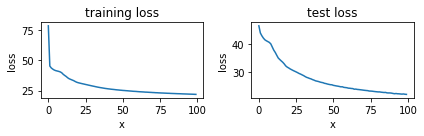

In [11]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(test_loss)
ax2.set(xlabel='x',ylabel='loss',title='test loss')
flg.tight_layout()
plt.show()

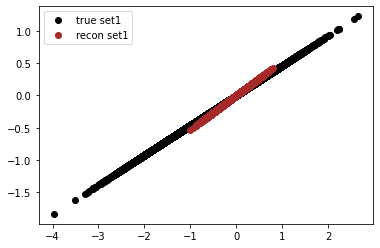

In [12]:
reconstruction1_x_cord = reconstruction1_pred[:,0].cpu().detach().numpy()
reconstruction1_y_cord = reconstruction1_pred[:,1].cpu().detach().numpy()
data1_x_cord = data1_val[:,0].cpu().detach().numpy()
data1_y_cord = data1_val[:,1].cpu().detach().numpy()
plt.plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
plt.plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='brown',label='recon set1')
plt.legend()
plt.show()